In [88]:
# basic
import numpy as np
import pandas as pd 
import datetime as dt 
from pandas_datareader import data as pdr 

# regression
import  statsmodels.api  as sm 

# optimization 
from scipy.optimize import minimize

# visulization
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 

In [ ]:
class Company_Data():
    """
    ticker     --> list (str)
    start ,end --> datetime 
    peirods    --> string
    """
    def __init__(self,tickers,start,end,periods):

        self.start   = start 
        self.end     = end 
        self.tickers = tickers
        self.periods = periods
    
    def get_data(self,ticker):

        self.df = pdr.get_data_yahoo(ticker,self.start,self.end).reset_index()
   
        return self.df 
    
    def Address_Date(self,date):
        
        date = str(date)
        return date[:10]
        
    def get_price_data(self):

        for i , ticker in enumerate(self.tickers) : 
            
            if i == 0 :
                Price_DF = self.get_data(ticker)
                Price_DF = Price_DF[['Date','Close']]
                Price_DF.columns = ['Date',str(ticker)]
            else:
                Merge_DF = self.get_data(ticker)[['Date','Close']]
                Merge_DF.columns = ['Date',str(ticker)]
                Price_DF = Price_DF.merge(Merge_DF,how='outer')
        
        Price_DF = Price_DF.fillna(value=0)
        Price_DF['Date'] = Price_DF.apply(lambda x : self.Address_Date(x['Date']),axis=1)
        Price_DF.index = Price_DF['Date']
        Price_DF = Price_DF.drop(['Date'],axis=1)

        return Price_DF



# ------------ Company_DF parameters ------------ 
start   = dt.datetime(2015,1,1)
end     = dt.datetime.now()
tickers = ["UBS","JPM","GS","MS","BAC"]

# ------------ ------------ ------------ ------------ 

Company_Price = Company_Data(tickers=tickers,start=start,end=end,periods="Daily")
Stock_DF      = Company_Price.get_price_data()
Stock_DF

In [ ]:
class Ken_French_Library():
    """
    Fama/French 3 Factors [Weekly]
    Fama/French 3 Factors [Daily]
    """

    def __init__(self,start,periods):

        self.start = start 
        self.periods = periods
    
    def get_data(self):

        research_factors = pdr.DataReader('F-F_Research_Data_Factors_'+str(self.periods),
                                      'famafrench', start=self.start)[0] 
        momentum_factor = pdr.DataReader('F-F_Momentum_Factor_daily',
                                     'famafrench', start=self.start)[0]

        five_factors = research_factors.join(momentum_factor).dropna()
        five_factors /= 100.
        five_factors.index = five_factors.index.tz_localize('utc')

        five_factors.columns = five_factors.columns.str.strip()

        self.five_factors = pd.DataFrame(five_factors)
        self.five_factors = self.five_factors.reset_index()
        self.five_factors['Date'] = self.five_factors.apply(lambda x : self.Address_Date(x['Date']),axis=1)
        self.five_factors.index   = self.five_factors['Date']
        self.five_factors = self.five_factors.drop(['Date'],axis=1)
        
        return self.five_factors
    
    def Address_Date(self,date):
        
        date = str(date)
        return date[:10]
        

    def __len__(self):
        return self.five_factors.shape[0]

Fama_French =  Ken_French_Library(start=dt.datetime(2015,1,1),periods='Daily')
FF_DF       =  Fama_French.get_data()
FF_DF

In [ ]:
class US_Market():

    """
    Major Market Index --> SPY(^GSPC) , DWJ
    """

    def __init__(self,start,end):
        self.start = start 
        self.end = end 
    
    def Address_Date(self,date):
        date = str(date)
        return date[:10]

    def get_prcie_df(self,ticker,plot):


        self.df = pdr.get_data_yahoo(ticker,self.start,self.end).reset_index()
        self.df['Date'] = self.df.apply(lambda x : self.Address_Date(x['Date']),axis=1)
        self.df.index   = self.df['Date']
        self.df         = self.df.drop(['Date'],axis=1)

        if plot == True :

            plot_df = self.df.tail(360)
            fig,ax = plt.subplots(figsize=(23,6))
            plt.title(str(ticker)+" Price Data")
            plt.plot(plot_df.index,plot_df['Close'])
            for i in range(plot_df.shape[0]):

                if i % 100 == 0:
                    plt.annotate(str(np.round(plot_df['Close'][i],decimals=2)),xy=(plot_df.index[i],plot_df['Close'][i]))
                    plt.scatter(plot_df.index[i],plot_df['Close'][i],marker="*",color='red')
                    plt.annotate("("+str(plot_df.index[i])[:10]+")",xy=(plot_df.index[i],float(plot_df['Close'][i])*(19/20)),color='red')
            
            plt.annotate(str(np.round(plot_df['Close'][-1],decimals=2)),xy=(plot_df.index[-1],plot_df['Close'][-1]))
            plt.scatter(plot_df.index[-1],plot_df['Close'][-1],marker="*",color='red')
            plt.annotate("("+str(plot_df.index[-1])[:10]+")",xy=(plot_df.index[-1],float(plot_df['Close'][-1])*(19/20)),color='red')

            plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=40))
            plt.gcf().autofmt_xdate()
            plt.grid()
            plt.show()

            return self.df



US_Market_Data = US_Market(start=dt.datetime(2015,1,1),end=dt.datetime.now())
US_SP500 = US_Market_Data.get_prcie_df(ticker='^GSPC',plot=True)
market_return = US_SP500['Close'].pct_change().dropna().mean() * np.sqrt(252)

US_SP500 

In [ ]:
def Multi_Assets_with_FF(Stock_DF,Fama_French_DF,Market_Data):

    
    Output_DF  = Stock_DF.pct_change().reset_index()
    Output_DF = Output_DF.dropna()

    # set index
    Output_DF.index = Output_DF['Date']
    Output_DF = Output_DF.drop(['Date'],axis=1)
    Output_DF = pd.merge(Output_DF,Fama_French_DF,how='inner',left_index=True, right_index=True)
    Output_DF = pd.merge(Output_DF,Market_Data['Close'].pct_change().dropna(),how='inner',left_index=True, right_index=True)


    return Output_DF


regression_df = Multi_Assets_with_FF(Stock_DF=Stock_DF,Fama_French_DF=FF_DF,Market_Data=US_SP500)
current_RF    = regression_df['RF'][-1]
regression_df

In [104]:
regression_return = regression_df[["UBS","JPM","GS","MS","BAC"]]

class Sharpe_Ratio_Portfolio_Optimization():

    def __init__(self,returns,risk_free_rate):

        self.initial_weight = np.ones((returns.shape[1],1)) ## setting expected portfolio return and the tolerate portfolio variance

        self.bounds = [(0,1),(0,1),(0,1),(0,1),(0,1)] # can't short stock
        self.mean   = returns.mean() * 252
        self.cov    = returns.cov()  * 252
        self.rf     = risk_free_rate
    
    def objective_function(self,w) :  # portfolio Shrape Ratio --> maximize

        w_tp = w.transpose()

        portfolio_risk = np.dot(np.dot(w_tp,self.cov),w)
        Shrape_Ratio   = (np.dot(w_tp,self.mean) - self.rf) / portfolio_risk

        return -Shrape_Ratio 

    def equality_constraint_1(self,w) : # weight sum = 1
        w_tp=w.transpose()
        return 1-np.dot(w_tp,self.initial_weight)

        
    def optimization(self):

        constraint_1 = {'type': 'eq','fun':  self.equality_constraint_1} # weight sum = 1
        constraint   = [constraint_1]

        result=minimize(self.objective_function,self.initial_weight,method='SLSQP',bounds=self.bounds,constraints=constraint)
        self.final_weight = result['x']

        return result['x']
        
    def print_result(self):

        for i in range(len(self.final_weight)):
            print('weights'+ str(i+1) + ': ',"{:.19f}".format(float(self.final_weight[i])))

        return self.final_weight
    
    def optimal_portfolio(self):

        optimal_portfolio_risk     = np.sqrt(np.dot(np.dot(self.final_weight.transpose(),self.cov),self.final_weight))
        optimal_portfolio_returns  = np.dot(self.final_weight.transpose(),self.mean)

        return optimal_portfolio_risk , optimal_portfolio_returns


model = Sharpe_Ratio_Portfolio_Optimization(returns=regression_return,risk_free_rate=current_RF)
sharpe_ratio_w = model.optimization()
sharpe_ratio_w = model.print_result()
SR_optimal_portfolio_risk , SR_optimal_portfolio_returns = model.optimal_portfolio()


weights1:  0.0000000000000000000
weights2:  0.9239655036611720273
weights3:  0.0299570478829923985
weights4:  0.0460774484558356470
weights5:  0.0000000000000001099


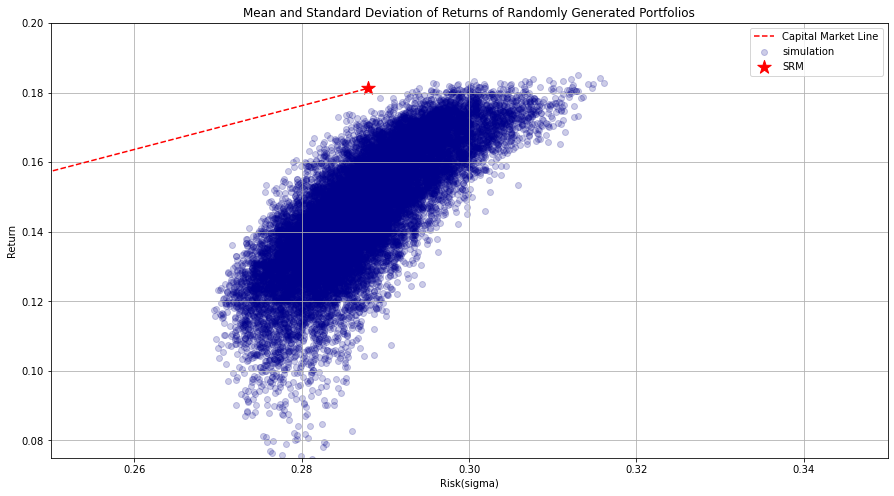

In [106]:

cov  = regression_return.cov() * 252   # construct cov matrix through returns (annualized)
mean = regression_return.mean()  * 252 # construct mean return (annualized)


trial_numbers = 20000
all_weights   = np.zeros((trial_numbers,mean.shape[0]))
all_risk      = np.zeros((trial_numbers))
all_returns   = np.zeros((trial_numbers))

for i in range(trial_numbers):

    # Random Uniform Generate Weights
    weights        = np.random.uniform(size=mean.shape[0])
    weights        = weights/np.sum(weights)
    all_weights[i] = weights
    
    # portfolio varience/risk
    portfolio_varience = np.dot(np.dot(weights.transpose(),cov),weights)
    risk               = np.sqrt(portfolio_varience)
    all_risk[i]        = risk

    # portfolio return
    portfolio_return   = np.dot(weights.transpose(),mean) 
    all_returns[i]     = portfolio_return


x = np.linspace(current_RF,SR_optimal_portfolio_risk,200)
y = np.linspace(current_RF,SR_optimal_portfolio_returns,200)


fig,ax = plt.subplots(figsize=(15,8))
ax.set_title("Mean and Standard Deviation of Returns of Randomly Generated Portfolios")
ax.scatter(all_risk,all_returns,marker="o",alpha=0.2,color='darkblue',label="simulation")
ax.scatter(SR_optimal_portfolio_risk,SR_optimal_portfolio_returns,color='red',marker='*',s=200,label='SRM')
ax.plot(x,y,color='red',label='Capital Market Line',linestyle='--')

ax.set_xlabel("Risk(sigma)")
ax.set_ylabel("Return")
ax.set_ylim(0.075,0.2)
ax.set_xlim(0.25,0.35)
ax.legend()
plt.grid()
plt.show()

(一.) Capital Market Line is CAL through market portfolio

Our optimal portfolio has a decently high return as well as less risk than any individual asset, as expected. Theoeretically, all investors should demand this optimal, tangent portfolio. 

If we accumulate the portfolios of all investors, we end up with the market portfolio, since all shares must be held by someone. This means that the tangency portfolio is the market portfolio, essentially saying that demand must equal supply.

When a risk-free asset is added to the portfolio, the Capital Asset Line turns into the Capital Market Line (CML). 

According to the CAPM, any stock or portfolio that lies to the right of CML would contain diversifiable risk and is therefore not efficient.

The mapping of each security's beta to its expected return results in the Security Markets Line. 

The difference between a security's return and the expected return as predicted by CAPM is known as the alpha.


The formula for plotting the SML is 

  --> Required return = risk-free rate of return + beta (market return - risk-free rate of return)

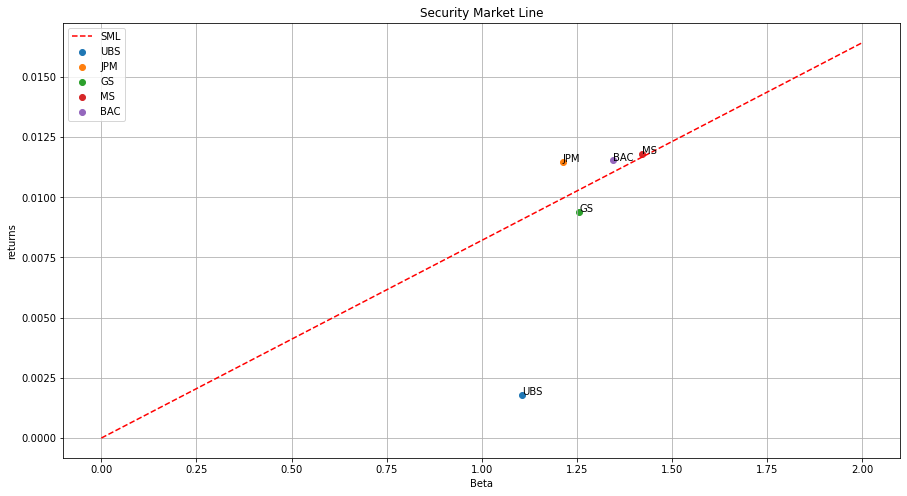

,Tickers,Beta,Expected Return
0,UBS,1.105707,0.001791
1,JPM,1.212898,0.011459
2,GS,1.255557,0.009384
3,MS,1.421748,0.011794
4,BAC,1.343760,0.011535


In [126]:
def OLS_Linear_Regression(y,x,print=None):

    # linear Regression
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    res   = model.fit()

    # Print Summary
    if print == "True":
        print(res.summary())

    return res.params

# Market Beta
def Constuct_Security_Beta(regression_df,tickers,market_return):

    regression_return = regression_df[tickers]
    x    = sm.add_constant( market_return ) 
    cols = regression_return.columns


    Equity_Beta_DF = pd.DataFrame()
    securities     = []
    equity_beta    = []

    for i in range(regression_return.shape[1]):

        y = regression_return[str(cols[i])]
        params = OLS_Linear_Regression(y,x)[-1]
        securities.append(cols[i])
        equity_beta.append(params)


    Equity_Beta_DF['Tickers'] = securities
    Equity_Beta_DF['Beta']    = equity_beta
    Equity_Beta_DF['Expected Return'] = np.array(regression_return.mean() * np.sqrt(252))

    return Equity_Beta


def plot_SML(pesudo_beta,Equity_Beta,risk_free_asset,market_expected_return):

    security_market_line = risk_free_asset + pesudo_beta * ( market_expected_return - risk_free_asset )

    fig,ax = plt.subplots(figsize=(15,8))
    ax.set_title("Security Market Line")
    for i in range(Equity_Beta.shape[0]):
        ax.scatter(Equity_Beta['Beta'][i] ,Equity_Beta['Expected Return'][i],label=Equity_Beta['Tickers'][i])
        ax.annotate(Equity_Beta['Tickers'][i],xy=(Equity_Beta['Beta'][i] ,Equity_Beta['Expected Return'][i]),size=10)
    ax.plot(pesudo_beta,security_market_line,color='r',label='SML',linestyle='--')

    ax.set_xlabel("Beta")
    ax.set_ylabel("returns")
    plt.legend()
    plt.grid()
    plt.show()
    
    return fig 



tickers         = ["UBS","JPM","GS","MS","BAC"]
risk_free_asset = current_RF
Equity_Beta     = Constuct_Security_Beta(regression_df,tickers=tickers,market_return=regression_df['Close'].values)
pesudo_beta     = np.linspace(0,2,20)
plot_SML(pesudo_beta,Equity_Beta,risk_free_asset,market_expected_return=regression_df['Close'].mean() * np.sqrt(252))
Equity_Beta
